In [1]:
from __future__ import print_function

import os
import random
import numpy as np
import tensorflow as tf
from six.moves import range
from six.moves import cPickle as pickle
from tqdm import tqdm
import matplotlib.pyplot as plt


#configuration for gpu usage
conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.4
conf.gpu_options.allow_growth = True
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
from tensorflow.python.keras.datasets.cifar10 import load_data
(train_dataset, train_labels), (test_dataset, test_labels) = load_data()
train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()
print('Dataset ready')

Dataset ready


==== Show CIFAR10 images ====


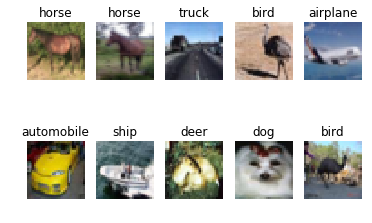

In [3]:
Row = 2
Column = 5
ListOfLabel = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("==== Show CIFAR10 images ====")


rand = random.randint(0, 49989)
images = train_dataset[rand:rand+10]
labels = train_labels[rand:rand+10].squeeze()
for i, image in enumerate(images):
    plt.subplot(Row, Column, i+1)
    plt.title('{}'.format(ListOfLabel[labels[i]]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
image_size = 32
num_labels = 10

train_X = train_dataset.reshape(-1, image_size, image_size, 3)
test_X = test_dataset.reshape(-1, image_size, image_size, 3)
train_y = (np.arange(10) == train_labels[:,None])
test_y = (np.arange(10) == test_labels[:,None])
print(train_X.shape, test_X.shape)
print(train_y.shape, test_y.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 10) (10000, 10)


In [5]:
training_iters = 20
learning_rate = 0.001 
batch_size = 128

n_input = image_size

n_classes = 10

In [6]:
x = tf.placeholder("float", [None, image_size, image_size, 3])
y = tf.placeholder("float", [None, n_classes])

In [7]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [8]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,3,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W02', shape=(5,5,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W03', shape=(5,5,64,32), initializer=tf.contrib.layers.xavier_initializer()),     
    'wd1': tf.get_variable('W1', shape=(16*16*32,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W2', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B02', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B03', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B1', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B2', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
def conv_net(x, weights, biases):  

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = tf.nn.relu(conv1)
    conv1 = maxpool2d(conv1, k=2)
    
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = tf.nn.relu(conv2)
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv3 = tf.nn.relu(conv3)
    conv3 = maxpool2d(conv3, k=2)

    fc1 = tf.reshape(conv1, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [10]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
init = tf.global_variables_initializer()

In [12]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    print('hi')
    for i in range(training_iters):
        print(i)
        for batch in tqdm(range(len(train_X)//batch_size)):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            opt = sess.run(optimizer, feed_dict={x:batch_x, y:batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y:batch_y})

        print("Iter " + str(i) + ", Loss= " + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc))

        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

hi
0


100%|████████████████████████████████████████| 390/390 [02:58<00:00,  2.32it/s]


Iter 0, Loss= 1.691201, Training Accuracy= 0.39062
Testing Accuracy: 0.39860
1


100%|████████████████████████████████████████| 390/390 [02:32<00:00,  3.01it/s]


Iter 1, Loss= 1.408105, Training Accuracy= 0.53125
Testing Accuracy: 0.47290
2


100%|████████████████████████████████████████| 390/390 [02:06<00:00,  3.08it/s]


Iter 2, Loss= 1.273509, Training Accuracy= 0.52344
Testing Accuracy: 0.49350
3


100%|████████████████████████████████████████| 390/390 [02:06<00:00,  3.11it/s]


Iter 3, Loss= 1.150114, Training Accuracy= 0.57031
Testing Accuracy: 0.50340
4


100%|████████████████████████████████████████| 390/390 [02:07<00:00,  3.04it/s]


Iter 4, Loss= 0.957605, Training Accuracy= 0.60938
Testing Accuracy: 0.51020
5


100%|████████████████████████████████████████| 390/390 [02:07<00:00,  3.01it/s]


Iter 5, Loss= 0.896881, Training Accuracy= 0.66406
Testing Accuracy: 0.52110
6


100%|████████████████████████████████████████| 390/390 [02:08<00:00,  3.01it/s]


Iter 6, Loss= 0.770734, Training Accuracy= 0.71875
Testing Accuracy: 0.52260
7


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  3.09it/s]


Iter 7, Loss= 0.796676, Training Accuracy= 0.70312
Testing Accuracy: 0.51440
8


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  3.09it/s]


Iter 8, Loss= 0.900583, Training Accuracy= 0.71875
Testing Accuracy: 0.48750
9


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  3.00it/s]


Iter 9, Loss= 0.737356, Training Accuracy= 0.75000
Testing Accuracy: 0.51450
10


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  3.15it/s]


Iter 10, Loss= 0.642030, Training Accuracy= 0.79688
Testing Accuracy: 0.51220
11


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  3.10it/s]


Iter 11, Loss= 0.561126, Training Accuracy= 0.80469
Testing Accuracy: 0.52470
12


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  3.11it/s]


Iter 12, Loss= 0.609169, Training Accuracy= 0.80469
Testing Accuracy: 0.50870
13


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  3.10it/s]


Iter 13, Loss= 0.529772, Training Accuracy= 0.82812
Testing Accuracy: 0.50590
14


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  3.12it/s]


Iter 14, Loss= 0.521381, Training Accuracy= 0.82031
Testing Accuracy: 0.51260
15


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  3.08it/s]


Iter 15, Loss= 0.473246, Training Accuracy= 0.85156
Testing Accuracy: 0.51270
16


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  2.86it/s]


Iter 16, Loss= 0.398259, Training Accuracy= 0.87500
Testing Accuracy: 0.52040
17


100%|████████████████████████████████████████| 390/390 [02:15<00:00,  3.09it/s]


Iter 17, Loss= 0.449466, Training Accuracy= 0.85156
Testing Accuracy: 0.51530
18


100%|████████████████████████████████████████| 390/390 [02:05<00:00,  3.20it/s]


Iter 18, Loss= 0.383006, Training Accuracy= 0.89062
Testing Accuracy: 0.52190
19


100%|████████████████████████████████████████| 390/390 [02:44<00:00,  2.26it/s]


Iter 19, Loss= 0.464936, Training Accuracy= 0.85938
Testing Accuracy: 0.50310


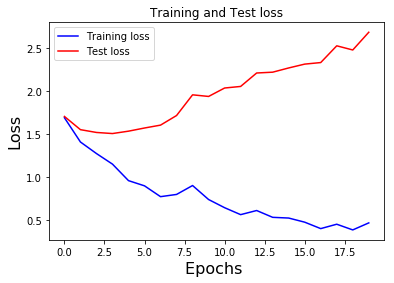

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()


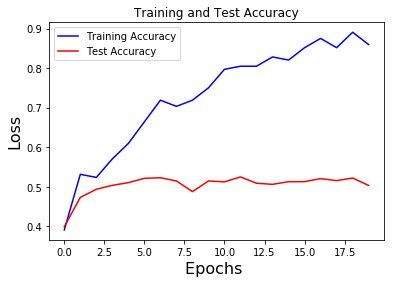

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

## _Homework_

02_convolutional_neural_networks.ipynb 실습 내용을 참고해 두 개 이상의 layer를 쌓아서 코드를 실행해보고, overfitting에 대해 알아본 후 이것을 이용해 결과 및 그래프를 분석해서 설명하세요.

Answer : training accuracy는 높은 반면 test accuracy가 낮은 경우, overfitting을 의심해볼 수 있다. 그래프 상에서 훈련이 거듭될 수 록 훈련 정확도는 0.9까지 높아지지만, 테스트 정확도는 0.5에서 더이상 늘지 않는다. overfitting을 확인할 수 있다. 

In [ ]:
ini